# Numerical Exercises 08

Before running this notebook, you need to...

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes    # zoomed up image libraries
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy.integrate import quad
import scipy.stats
from scipy.optimize import curve_fit
from scipy.optimize import minimize_scalar
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.style as style 
style.use('tableau-colorblind10')

# Exercise 08.2
## Variational Monte Carlo Methods (VMC)

The goal of this exercise is to minimize the energy of the following Hamiltonian, representing a single quantum particle in 1D space: 

$$
\hat H = \frac{\hat p^2}{2m} + \hat x^4 - \frac{5}{2} \hat x^2,
$$

exploiting the variational principle. As a matter of fact, the Schroedinger equation for such Hamiltonian (or more in general for a many-body hamiltonian) is not exactly solvable, and to get an estimate of the ground state energy we have to use the variational principal, which states that the variational energy $E_T$ for any wavefunction $\psi_T$ will always be higher than the ground state energy:

$$
E_T = \frac{\langle \psi_T | \hat H | \psi_T \rangle}{\langle \psi_T| \psi_T \rangle} \geq E_0 = \frac{\langle \psi_0 | \hat H | \psi_0 \rangle}{\langle \psi_0| \psi_0 \rangle}.
$$

To do so, we first choose an appropriate family of eigenfunctions: our choice is

$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}},
$$

which has the same parity as the Hamiltonian potential, and $\mu$ and $\sigma$ are the variational parameters to optimize. Then the $E_{GS}$ will be approximated by: 

$$
\langle {\hat H} \rangle_T =  
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)} =
\int dx p(x) E_{loc}(x).
$$

The algorithm is:

1. Choose start value for $\mu$ and $\sigma$
2. **Metropolis algorithm** to generate $x$ points distributed as $p(x)$
3. use these points to compute a **MC** integration over $E_{loc}$ with blocking method to find uncertainties; it's worth noticing that the computation of $E_{GS}$ is exact, because its uncertainty is within the statistical uncertainty of the Monte Carlo calculation. Our estimate  will be given by:

$$
\langle\hat{H}\rangle_T=\frac{1}{M} \sum_{i=1}^M E_\text{loc}(x_i),
$$

   where $M$ is the number of sampled points.

4. Tuning $\mu$ and $\sigma$, and repeat from 2., until a best estimation of $E_{GS}$ is reached

In the following graph we compare our result with the one obtained with the following consideration: even though the Schroedinger equation has no analytical solution, we can discretize the 3D space with a lattice of $N$ points and evaluate the wavefunction in each of these points. 

Under this consideration, the Schroedinger equation can be re-written in matricial form as follow: 

$$
\begin{bmatrix}
 \frac{\hbar^2}{m\,dx^2}+V(x_1)& -\frac{\hbar^2}{2m\,dx^2} & 0 & \dots  & 0 \\
-\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_2) & -\frac{\hbar^2}{2m\,dx^2} & \dots  & 0 \\
 0                        & -\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_3) & \dots  & 0 \\
 \vdots                   & \vdots                    & \vdots & \ddots & \vdots \\
 0                    & 0                & 0 & \dots  & \frac{\hbar^2}{m\,dx^2}+V(x_N)
\end{bmatrix}
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
= E
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
$$

and we can obtain the eigenvalues and eigenstates of this matrix with the calculation below.

Here we show the theoretical predictions for the probability densities of the ground state and of the first two excited states from the matricial Schroedinger's equation.

Ground state energy:  -0.46045845079911835
1st excited state energy:  0.09744706661807169
2nd excited state energy:  1.9718077373830059


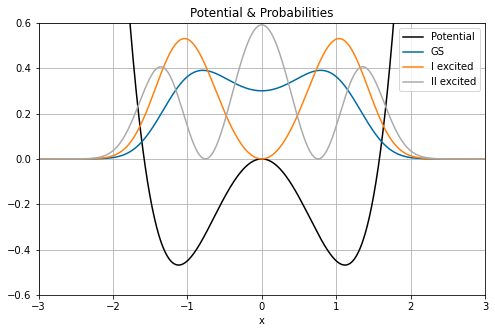

In [3]:
MU=0.79
SIGMA=0.62
def Vpot(x): return (x**2 - 2.5)*x**2

def p(x, MU, SIGMA):
    return (np.exp(-(x-MU)**2/(2*(SIGMA)**2)) + np.exp(-(x+MU)**2/(2*(SIGMA)**2)))**2
norm = quad(p, -3, 3, args=(MU,SIGMA))[0]

N = 1000 # number of iterations
hbar = 1
m = 1

x = np.linspace(-3, 3, 1000)
dx = x[1] - x[0] # the step size
V = Vpot(x)

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)
E,ps = np.linalg.eigh(H)
ps = np.transpose(ps)
ps = ps/np.sqrt(dx)

print("Ground state energy: ", E[0])
print("1st excited state energy: ", E[1])
print("2nd excited state energy: ", E[2])

# Plot a few things
plt.figure(figsize=(8,5))
scale = 0.3
plt.plot(x, scale*V, color="Black", label="Potential") # plot the potential
plt.plot(x,(ps[0])**2, label='GS')
plt.plot(x,(ps[1])**2, label='I excited')
plt.plot(x,(ps[2])**2, label='II excited')
plt.title("Potential & Probabilities")
plt.legend()
plt.xlabel("x")
plt.grid(True)
plt.xlim((-3,3))
plt.ylim((-0.6,0.6))
plt.show()

Last but not least, we plot the graph of $|\Psi_T(x)|^2$, compared with the solution of the discretized Schroedinger equation and its analytical prediction (the normalized wavefunction $\Psi_T^{\mu, \sigma}$ where the optimal parameters are chose)